# Week 3 Peer Review -> Histopathologic Cancer Detection Kaggle Competition.

This project is in response to the Kaggle compeition located at https://www.kaggle.com/c/histopathologic-cancer-detection/

Here is the background and intro ripped from the compition : 

n this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

Now let's begin by making our global library declatations and import some of the data.

In [167]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='joblib')


base_path = r'C:\Users\derek\Downloads\histopathologic-cancer-detection'
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
labels_path = os.path.join(base_path, "train_labels.csv")

df = pd.read_csv(labels_path)
print("Labels CSV loaded:")
print(df.head(5))
df.info()
print("\nDataFrame dimensions:", df.shape)
print("\nChecking for missing values:")
print(df.isnull().sum())

Labels CSV loaded:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

DataFrame dimensions: (220025, 2)

Checking for missing values:
id       0
label    0
dtype: int64


# Exploratory Data Analysis

First thing to do is to check how much data we have and to see if we have any missing values


In [170]:
# Read in the labels csv training file and take a quick look at it
df = pd.read_csv(labels_path)
print("Labels CSV loaded:")
print(df.head(5))
df.info()
print("\nDataFrame dimensions:", df.shape)
print("\nChecking for missing values:")
print(df.isnull().sum())

Labels CSV loaded:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

DataFrame dimensions: (220025, 2)

Checking for missing values:
id       0
label    0
dtype: int64


We can see no missing data, we have a data frame that contains the id of the image as well as the label classification.  We can see there are a total of 220,025 images in the training dataset.

Now let's continue to do a bit further and see what is the breakdown of label classifications for cancer vs non-cancer.

C:\Users\derek\AppData\Local\Temp\ipykernel_532512\2874449395.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['skyblue', 'salmon'])


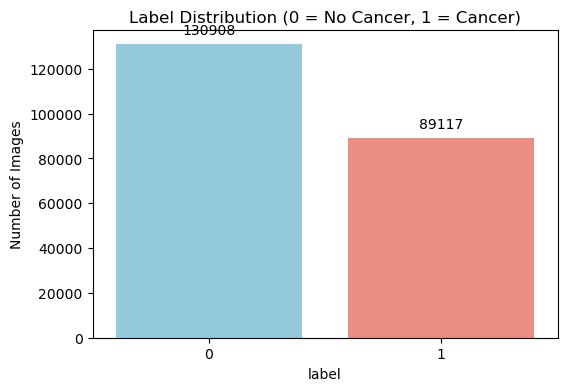

Missing values:
id       0
label    0
dtype: int64


In [173]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette=['skyblue', 'salmon'])
plt.title('Label Distribution (0 = No Cancer, 1 = Cancer)')

# Annotate counts
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('Number of Images')
plt.show()

print("Missing values:")
print(df.isnull().sum())

This all seems in order.  Now let's inspect a few of the images by classification and make sure we can see them normally.  Let's also take a look at the images themselves.

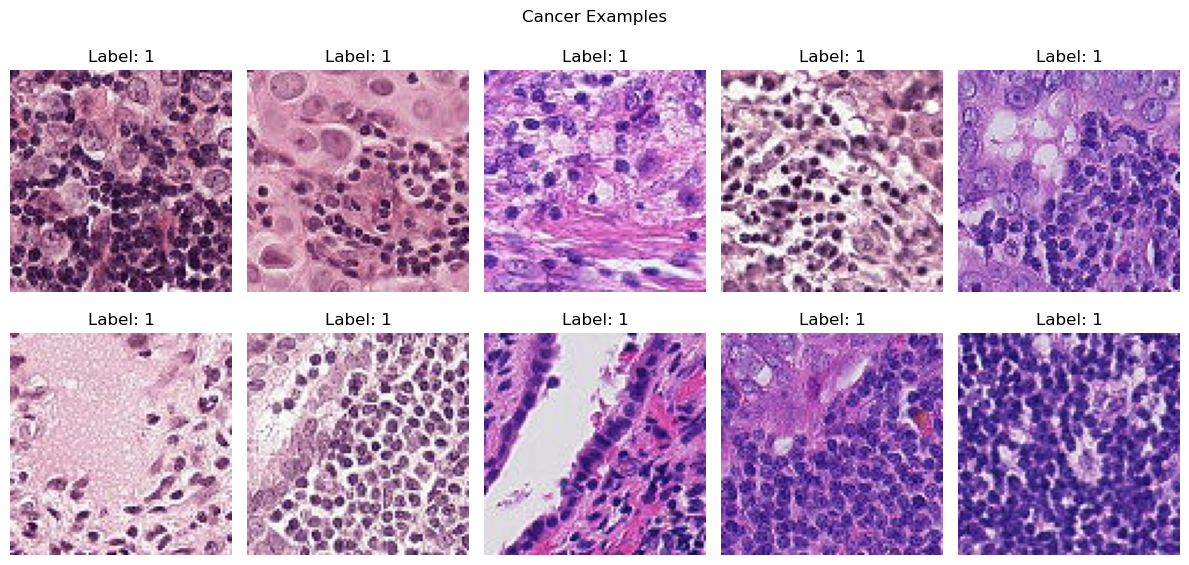

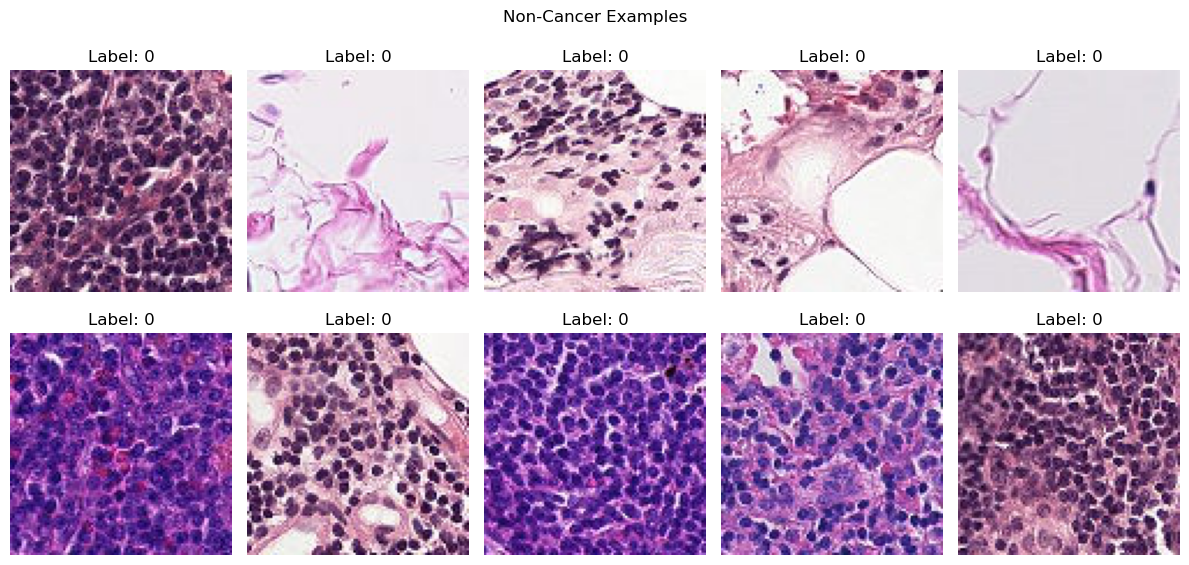

In [204]:
def show_images(df_sample, title, train_path):
    plt.figure(figsize=(12,6))
    for idx, row in enumerate(df_sample.iterrows()):
        img_path = os.path.join(train_path, row[1]['id'] + '.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {row[1]['label']}")
        if idx == 9:
            break
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Set train_path to your local directory containing the images
train_path = r'C:\Users\derek\Downloads\histopathologic-cancer-detection\train'

show_images(df[df['label']==1].sample(10), "Cancer Examples", train_path)
show_images(df[df['label']==0].sample(10), "Non-Cancer Examples", train_path)


These are just a few sample images from each group.  You can see quite a bit of white space in a few of these and in others you can see cellular formations easily.  Let's move onto something important.  Let's look at the color distributions witin the samples.

## Pixel Intensity

100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2369.06it/s]


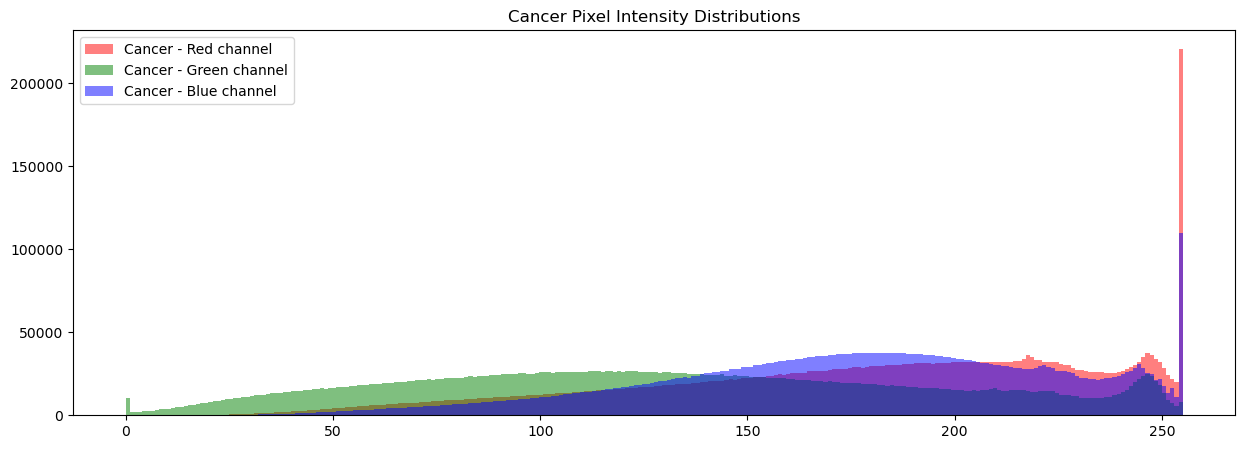

100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2678.92it/s]


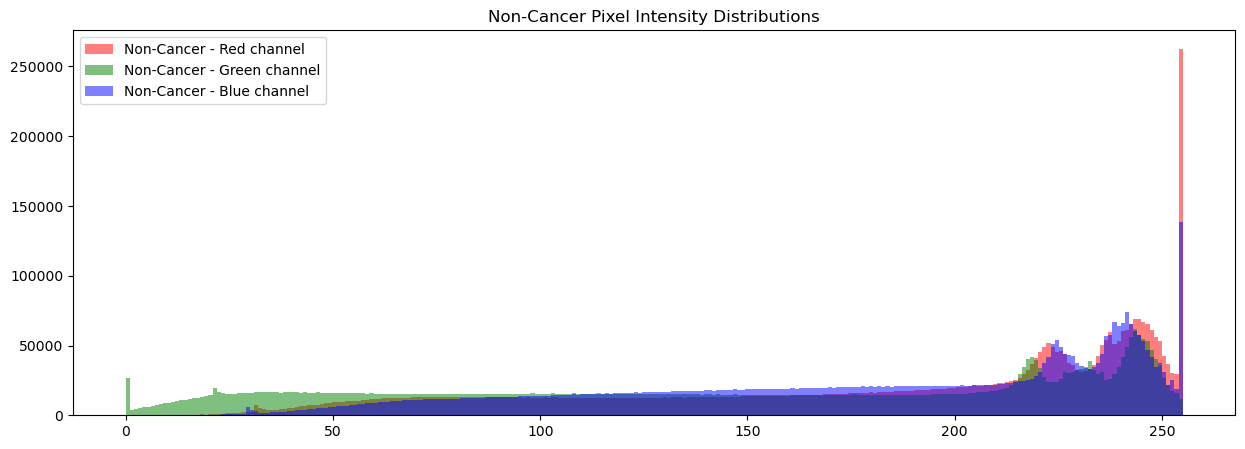

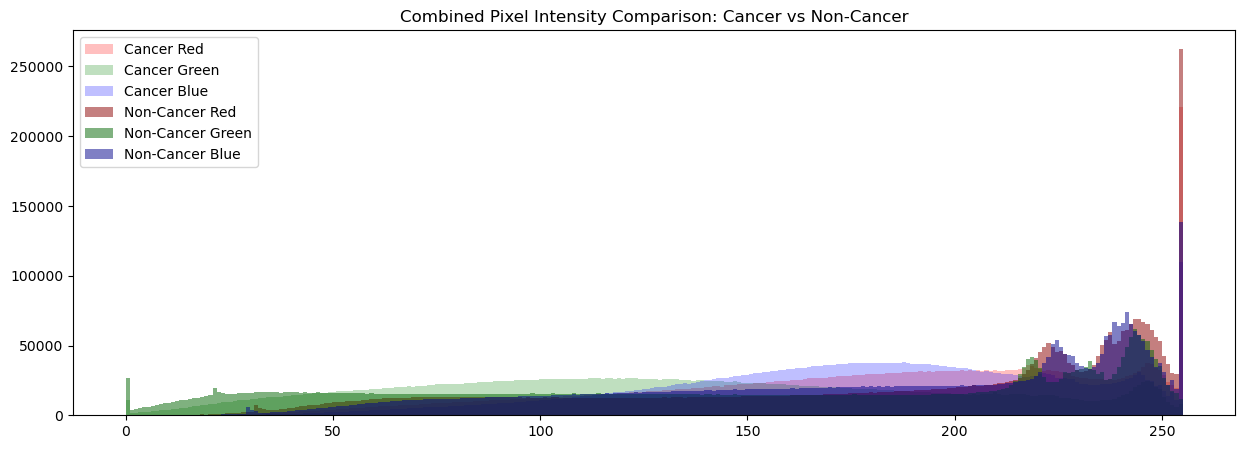


Pixel Intensity Statistical Summary:
                Cancer  Non-Cancer
Red Mean    178.421662  182.111712
Red Std      54.192141   65.091996
Green Mean  131.638339  147.995217
Green Std    62.649623   77.184198
Blue Mean   176.236364  178.889584
Blue Std     47.559920   60.387563


In [175]:
# Pixel Intensity Distribution Analysis

# Cancer Pixel Intensity
cancer_folder_sample = df[df['label'] == 1].sample(500, random_state=42)
r_vals_cancer = []
g_vals_cancer = []
b_vals_cancer = []

for idx, row in tqdm(cancer_folder_sample.iterrows(), total=len(cancer_folder_sample)):
    img_path = os.path.join(train_path, row['id'] + '.tif')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r_vals_cancer.append(img[:,:,0].flatten())
    g_vals_cancer.append(img[:,:,1].flatten())
    b_vals_cancer.append(img[:,:,2].flatten())

r_vals_cancer = np.concatenate(r_vals_cancer)
g_vals_cancer = np.concatenate(g_vals_cancer)
b_vals_cancer = np.concatenate(b_vals_cancer)

plt.figure(figsize=(15,5))
plt.hist(r_vals_cancer, bins=256, color='r', alpha=0.5, label='Cancer - Red channel')
plt.hist(g_vals_cancer, bins=256, color='g', alpha=0.5, label='Cancer - Green channel')
plt.hist(b_vals_cancer, bins=256, color='b', alpha=0.5, label='Cancer - Blue channel')
plt.legend()
plt.title('Cancer Pixel Intensity Distributions')
plt.show()

# Non-Cancer Pixel Intensity
non_cancer_folder_sample = df[df['label'] == 0].sample(500, random_state=42)
r_vals_non_cancer = []
g_vals_non_cancer = []
b_vals_non_cancer = []

for idx, row in tqdm(non_cancer_folder_sample.iterrows(), total=len(non_cancer_folder_sample)):
    img_path = os.path.join(train_path, row['id'] + '.tif')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r_vals_non_cancer.append(img[:,:,0].flatten())
    g_vals_non_cancer.append(img[:,:,1].flatten())
    b_vals_non_cancer.append(img[:,:,2].flatten())

r_vals_non_cancer = np.concatenate(r_vals_non_cancer)
g_vals_non_cancer = np.concatenate(g_vals_non_cancer)
b_vals_non_cancer = np.concatenate(b_vals_non_cancer)

plt.figure(figsize=(15,5))
plt.hist(r_vals_non_cancer, bins=256, color='r', alpha=0.5, label='Non-Cancer - Red channel')
plt.hist(g_vals_non_cancer, bins=256, color='g', alpha=0.5, label='Non-Cancer - Green channel')
plt.hist(b_vals_non_cancer, bins=256, color='b', alpha=0.5, label='Non-Cancer - Blue channel')
plt.legend()
plt.title('Non-Cancer Pixel Intensity Distributions')
plt.show()

# Combined Pixel Intensity Comparison
plt.figure(figsize=(15,5))
plt.hist(r_vals_cancer, bins=256, color='r', alpha=0.25, label='Cancer Red')
plt.hist(g_vals_cancer, bins=256, color='g', alpha=0.25, label='Cancer Green')
plt.hist(b_vals_cancer, bins=256, color='b', alpha=0.25, label='Cancer Blue')
plt.hist(r_vals_non_cancer, bins=256, color='darkred', alpha=0.5, label='Non-Cancer Red')
plt.hist(g_vals_non_cancer, bins=256, color='darkgreen', alpha=0.5, label='Non-Cancer Green')
plt.hist(b_vals_non_cancer, bins=256, color='darkblue', alpha=0.5, label='Non-Cancer Blue')
plt.legend()
plt.title('Combined Pixel Intensity Comparison: Cancer vs Non-Cancer')
plt.show()

# Statistical Summary of Pixel Intensities

# Create summaries for Cancer
cancer_summary = {
    'Red Mean': np.mean(r_vals_cancer),
    'Red Std': np.std(r_vals_cancer),
    'Green Mean': np.mean(g_vals_cancer),
    'Green Std': np.std(g_vals_cancer),
    'Blue Mean': np.mean(b_vals_cancer),
    'Blue Std': np.std(b_vals_cancer)
}

# Create summaries for Non-Cancer
non_cancer_summary = {
    'Red Mean': np.mean(r_vals_non_cancer),
    'Red Std': np.std(r_vals_non_cancer),
    'Green Mean': np.mean(g_vals_non_cancer),
    'Green Std': np.std(g_vals_non_cancer),
    'Blue Mean': np.mean(b_vals_non_cancer),
    'Blue Std': np.std(b_vals_non_cancer)
}

# Combine into a DataFrame for clean viewing
summary_df = pd.DataFrame({
    'Cancer': cancer_summary,
    'Non-Cancer': non_cancer_summary
})

print("\nPixel Intensity Statistical Summary:")
print(summary_df)



These might seem daunting at first.  There is a huge spide at pixel intensity 255 of each of the graphs.  This is completely normal since this would represent white in the color spectrum.  In the histopathology slides there is quite a bit of white space surrounding the tissue and there is white space held within the tissue as well.  I think more importantly there is a bit of a double bump in the pixel intensities for non-cancer tissue images.  This is something to keep in mind if we see any irregularities later.

Here are the raw numbers : 

In [178]:
def pixel_stats(df_sample):
    means = []
    stds = []
    for idx, row in enumerate(df_sample.iterrows()):
        img_path = os.path.join(train_path, row[1]['id'] + '.tif')
        img = cv2.imread(img_path)
        img = img/255.0
        means.append(img.mean())
        stds.append(img.std())
        if idx == 999:
            break
    print(f"Mean pixel intensity (avg of 1000 samples): {np.mean(means):.4f}")
    print(f"Std pixel intensity (avg of 1000 samples): {np.mean(stds):.4f}")

pixel_stats(df.sample(1000))

Mean pixel intensity (avg of 1000 samples): 0.6501
Std pixel intensity (avg of 1000 samples): 0.2004


These seem to be normal so let's continue with the EDA.  Let's perform a t-SNE analysis to look for clustering within the tissues themselves.  If there is high correlation with a too many of the imgages, then the model will likely struggle to capture the preoper relationship.



100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2042.16it/s]


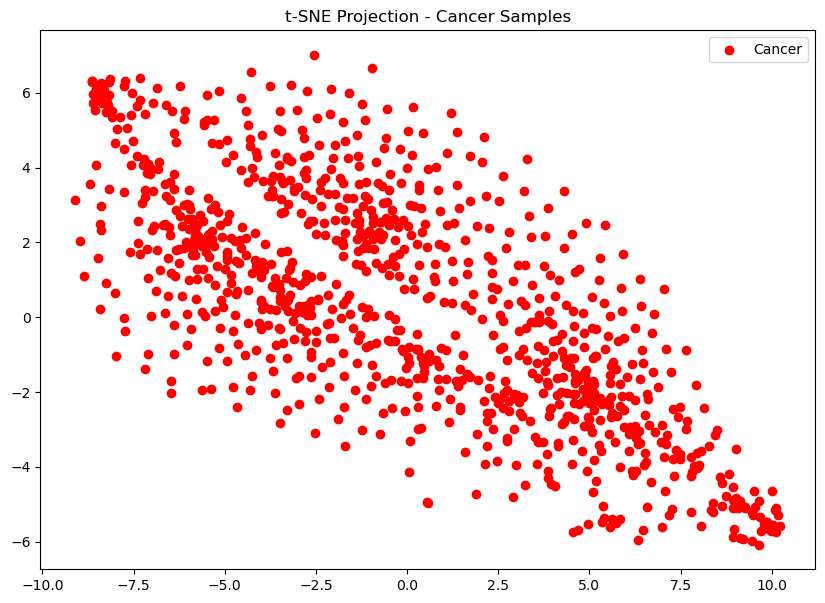

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2069.67it/s]


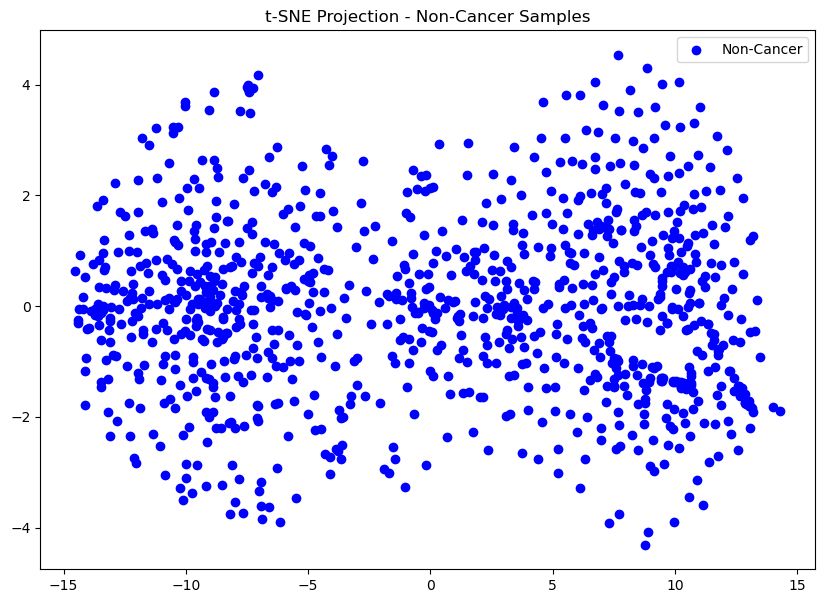

100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1966.41it/s]


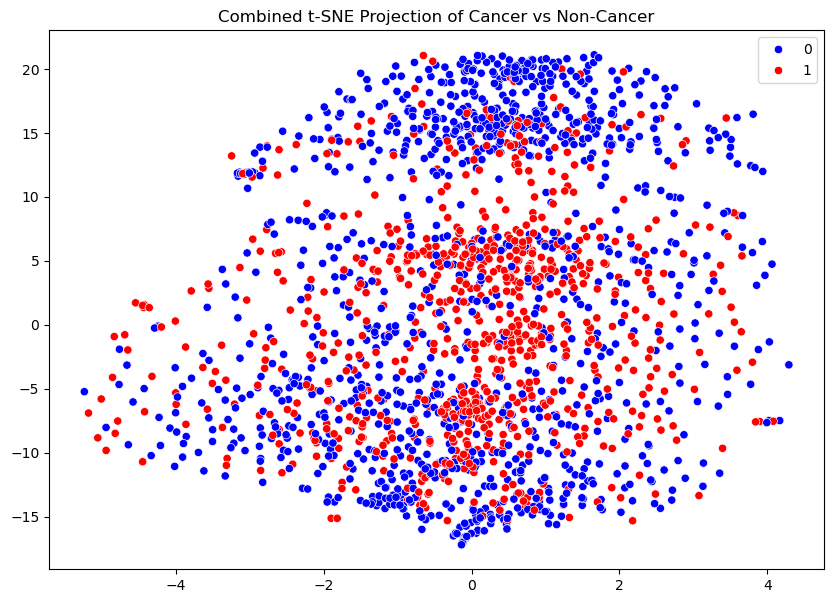

In [180]:
# t-SNE Analysis

def load_images(df_subset):
    X = []
    y = []
    for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        img_path = os.path.join(train_path, row['id'] + '.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        X.append(img)
        y.append(row['label'])
    return np.array(X), np.array(y)

# t-SNE for Cancer only
cancer_sampled_df = df[df['label']==1].sample(1000, random_state=42)
X_cancer, y_cancer = load_images(cancer_sampled_df)
X_cancer_flat = X_cancer.reshape(len(X_cancer), -1)

cancer_tsne = TSNE(n_components=2, random_state=42)
X_cancer_tsne = cancer_tsne.fit_transform(X_cancer_flat)

plt.figure(figsize=(10,7))
plt.scatter(X_cancer_tsne[:,0], X_cancer_tsne[:,1], c='red', label='Cancer')
plt.title('t-SNE Projection - Cancer Samples')
plt.legend()
plt.show()

# t-SNE for Non-Cancer only
non_cancer_sampled_df = df[df['label']==0].sample(1000, random_state=42)
X_non_cancer, y_non_cancer = load_images(non_cancer_sampled_df)
X_non_cancer_flat = X_non_cancer.reshape(len(X_non_cancer), -1)

non_cancer_tsne = TSNE(n_components=2, random_state=42)
X_non_cancer_tsne = non_cancer_tsne.fit_transform(X_non_cancer_flat)

plt.figure(figsize=(10,7))
plt.scatter(X_non_cancer_tsne[:,0], X_non_cancer_tsne[:,1], c='blue', label='Non-Cancer')
plt.title('t-SNE Projection - Non-Cancer Samples')
plt.legend()
plt.show()

# Combined t-SNE plot
sampled_df = df.sample(2000, random_state=42)
X_sample, y_sample = load_images(sampled_df)
X_flat = X_sample.reshape(len(X_sample), -1)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_sample, palette={0: 'blue', 1: 'red'})
plt.title('Combined t-SNE Projection of Cancer vs Non-Cancer')
plt.show()


This is a bit interesting to look at the t-SNE graphs of within cancer and non-cancer groups.  There looks to be some major groupings happening within each of the groups.  In the cancer group there is a diagonal skewness to the data and in the non-cancer it looks more like a butterfly pattern.  Put together there does seem to be a bit more randomness, but within groupings there is some evidence of clustering.  We should keep this in mind when putting together any final reasonable conclusions.  However, for now we will continue with the analysis.

# Model Development

Here we will design the models.  The first model will be a simplistic CNN model and the second model will be a ResNet model.

In [182]:
sample_df = df.sample(10000, random_state=42)
X, y = load_images(sample_df)

# Simple CNN model
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ResNet50 model
def build_resnet_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(96,96,3), pooling='avg')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

X_preprocessed = preprocess_input(X * 255.0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_pre, X_val_pre, _, _ = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

simple_cnn = build_simple_cnn()
resnet_cnn = build_resnet_model()

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1109.81it/s]
C:\Users\derek\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that the models have been drawn out.  Now it is time to fit the model based on the training dataset that we have put together

In [184]:
history_simple = simple_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
history_resnet = resnet_cnn.fit(X_train_pre, y_train, epochs=10, validation_data=(X_val_pre, y_val))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6788 - loss: 0.6349 - val_accuracy: 0.7910 - val_loss: 0.4598
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.7862 - loss: 0.4676 - val_accuracy: 0.7570 - val_loss: 0.4861
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.7958 - loss: 0.4455 - val_accuracy: 0.7460 - val_loss: 0.5012
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8025 - loss: 0.4402 - val_accuracy: 0.7920 - val_loss: 0.4465
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.8202 - loss: 0.4052 - val_accuracy: 0.7990 - val_loss: 0.4402
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8306 - loss: 0.3885 - val_accuracy: 0.7995 - val_loss: 0.4252
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8570 - loss: 0.3329 - val_accuracy: 0.7835 - val_loss: 0.4950
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8872 - loss: 0.2827 - 

Now that both models have been created and fitted, let's do the standard evaluation metrics on both models and compare.

# Results


Final Side-by-Side Model Comparison:
Empty DataFrame
Columns: []
Index: []
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Simple CNN Validation Accuracy: 0.8055
Simple CNN Validation ROC AUC: 0.8637
Simple CNN Confusion Matrix:
True Negatives: 985 (49.25%)
False Positives: 181 (9.05%)
False Negatives: 208 (10.40%)
True Positives: 626 (31.30%)
Precision: 0.7757
Recall: 0.7506
F1 Score: 0.7629


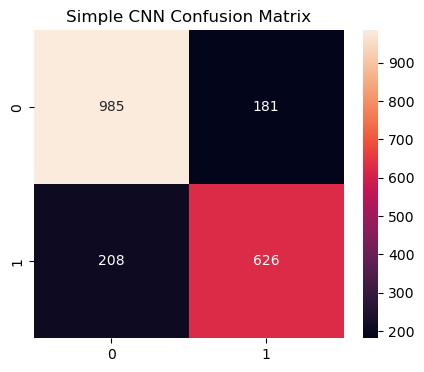

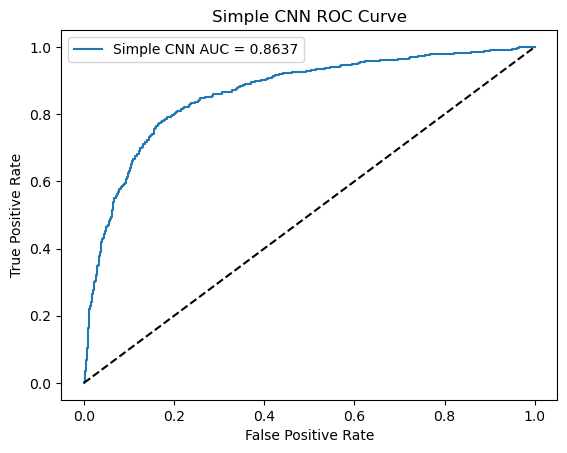

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step
ResNet50 Validation Accuracy: 0.8745
ResNet50 Validation ROC AUC: 0.9410
ResNet50 Confusion Matrix:
True Negatives: 1078 (53.90%)
False Positives: 88 (4.40%)
False Negatives: 163 (8.15%)
True Positives: 671 (33.55%)
Precision: 0.8841
Recall: 0.8046
F1 Score: 0.8424


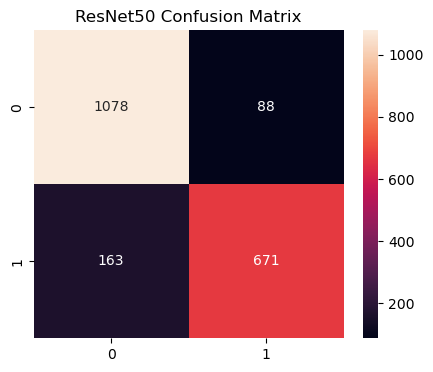

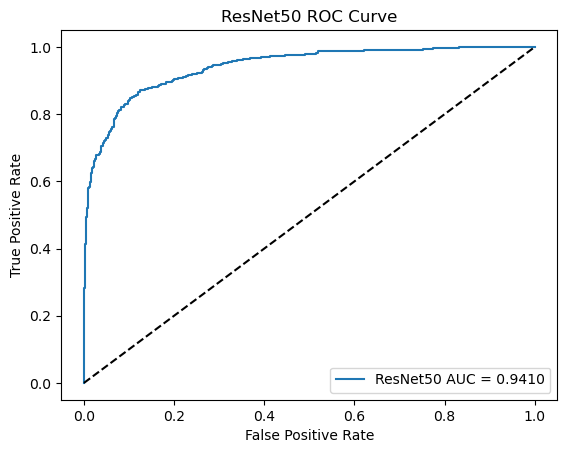


Final Side-by-Side Model Comparison:
            Accuracy   ROC AUC  Precision    Recall  F1 Score  True Negatives  \
Simple CNN    0.8055  0.863681   0.775713  0.750600  0.762949           985.0   
ResNet50      0.8745  0.941029   0.884058  0.804556  0.842436          1078.0   

            False Positives  False Negatives  True Positives  
Simple CNN            181.0            208.0           626.0  
ResNet50               88.0            163.0           671.0  


In [186]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_summary = {}

def evaluate_model(model, X_val, y_val, model_name):
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    cm = confusion_matrix(y_val, y_pred)

    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    metrics_summary[model_name] = {
        'Accuracy': acc,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp
    }

    print(f"{model_name} Validation Accuracy: {acc:.4f}")
    print(f"{model_name} Validation ROC AUC: {roc_auc:.4f}")
    print(f"{model_name} Confusion Matrix:")
    print(f"True Negatives: {tn} ({tn/total:.2%})")
    print(f"False Positives: {fp} ({fp/total:.2%})")
    print(f"False Negatives: {fn} ({fn/total:.2%})")
    print(f"True Positives: {tp} ({tp/total:.2%})")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    return acc, roc_auc

...

# After evaluating both models:

comparison_df = pd.DataFrame(metrics_summary).T

print("\nFinal Side-by-Side Model Comparison:")
print(comparison_df)

acc_simple, auc_simple = evaluate_model(simple_cnn, X_val, y_val, "Simple CNN")
acc_resnet, auc_resnet = evaluate_model(resnet_cnn, X_val_pre, y_val, "ResNet50")

comparison_df = pd.DataFrame({
    'Model': ['Simple CNN', 'ResNet50'],
    'Accuracy': [acc_simple, acc_resnet],
    'ROC AUC': [auc_simple, auc_resnet]
})

#print("\nFinal Model Comparison:")
#print(comparison_df)

comparison_df = pd.DataFrame(metrics_summary).T

print("\nFinal Side-by-Side Model Comparison:")
print(comparison_df)


Here we can see in most every evaluation metric the ResNet model outperformed our simple CNN model.  This isn't surprising, but it does highlight a few important features.  First, the ROC is significantly higher for ResNet over simple.

Now let's take a look at the training history to see what the accuracy and loss functions look like.

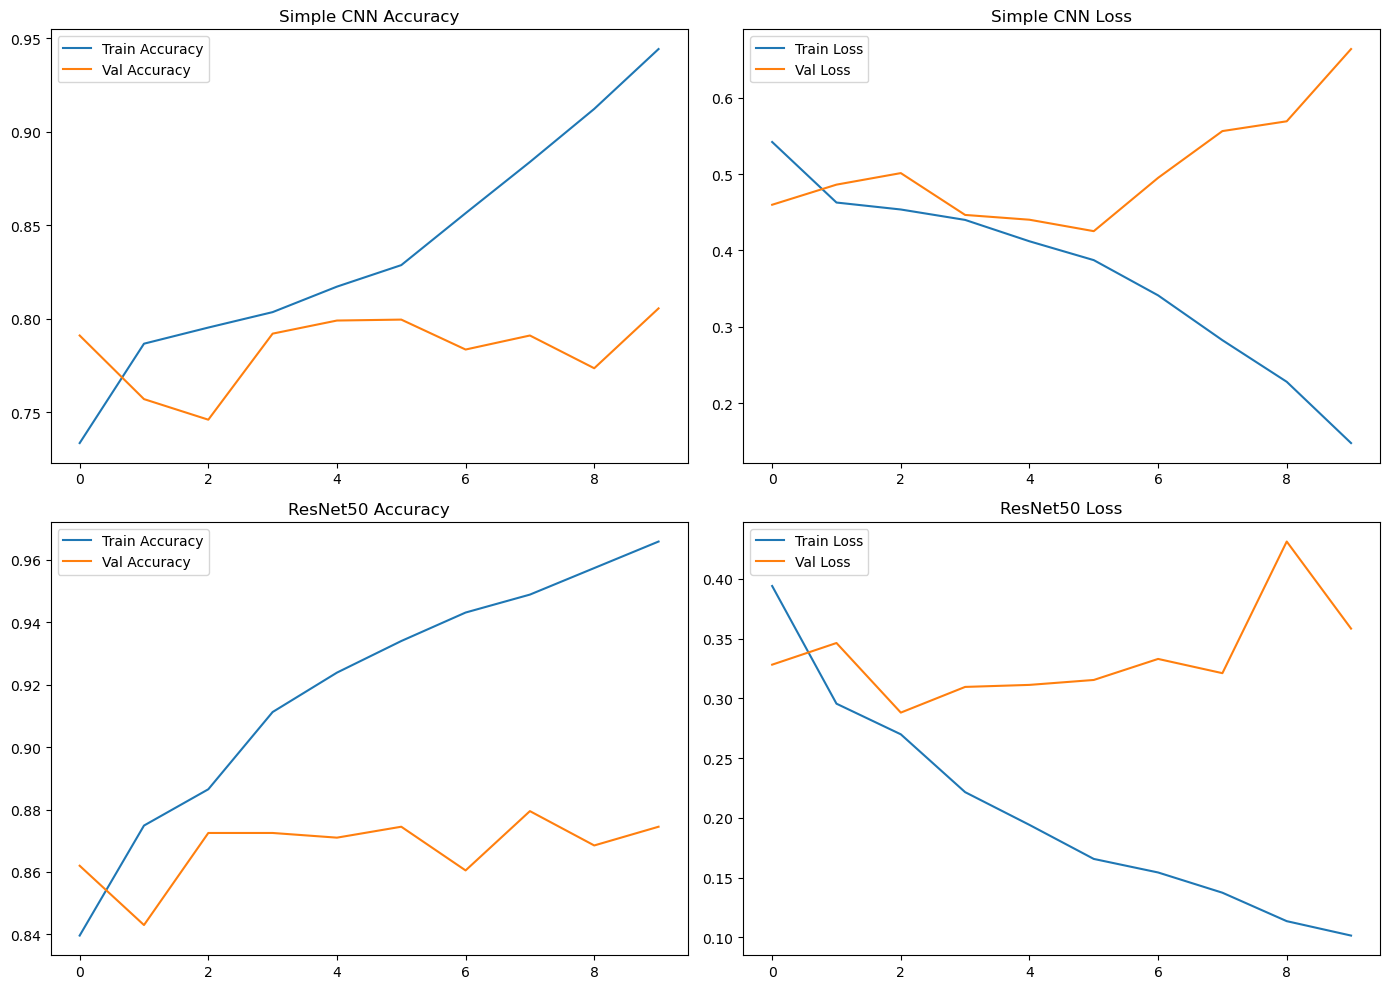

In [188]:
# Plot training history

fig, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0,0].plot(history_simple.history['accuracy'], label='Train Accuracy')
axs[0,0].plot(history_simple.history['val_accuracy'], label='Val Accuracy')
axs[0,0].set_title('Simple CNN Accuracy')
axs[0,0].legend()

axs[0,1].plot(history_simple.history['loss'], label='Train Loss')
axs[0,1].plot(history_simple.history['val_loss'], label='Val Loss')
axs[0,1].set_title('Simple CNN Loss')
axs[0,1].legend()

axs[1,0].plot(history_resnet.history['accuracy'], label='Train Accuracy')
axs[1,0].plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
axs[1,0].set_title('ResNet50 Accuracy')
axs[1,0].legend()

axs[1,1].plot(history_resnet.history['loss'], label='Train Loss')
axs[1,1].plot(history_resnet.history['val_loss'], label='Val Loss')
axs[1,1].set_title('ResNet50 Loss')
axs[1,1].legend()

plt.tight_layout()
plt.show()


From the above graphs it continues to show that the ResNet model outperformed our simple CNN.  It looks like we have done sufficient epochs since the graphs are both zeroing out in the 8-10 epochs for training loss.  Based on these graphs we can be reasonably sure that extending the models is unnecessary.

## Generate Kaggle submission using the ResNet model

In [190]:
# Load testing images
test_filenames = os.listdir(test_path)
print(f"Number of test images: {len(test_filenames)}")

test_df = pd.DataFrame({'id': [fname.split('.')[0] for fname in test_filenames]})
print(test_df.head())

def load_test_images(test_filenames):
    X_test = []
    for fname in tqdm(test_filenames):
        img_path = os.path.join(test_path, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        X_test.append(img)
    return np.array(X_test)

# Load and preprocess
X_test = load_test_images(test_filenames)
X_test_preprocessed = preprocess_input(X_test * 255.0)

# Make Predictions!
test_preds_prob = resnet_cnn.predict(X_test_preprocessed)
test_preds_label = (test_preds_prob > 0.5).astype(int).reshape(-1)

# Create submission
submission = pd.DataFrame({
    'id': [fname.split('.')[0] for fname in test_filenames],
    'label': test_preds_label
})

print(submission.head())

# Save in csv format for Kaggle upload
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created!")

Number of test images: 57458
                                         id
0  00006537328c33e284c973d7b39d340809f7271b
1  0000ec92553fda4ce39889f9226ace43cae3364e
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3  000253dfaa0be9d0d100283b22284ab2f6b643f6
4  000270442cc15af719583a8172c87cd2bd9c7746


100%|██████████████████████████████████████████████████████████████████████████████| 57458/57458 [00:51<00:00, 1111.15it/s]


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 318s 177ms/step
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4  000270442cc15af719583a8172c87cd2bd9c7746      0
Submission file 'submission.csv' created!


## Step 5 - Results and Conclusions

This notebook contains 2 different CNN archtitectures that aims to solve the Histopathologic Cancer Detection Kaggle competition.  In one model, a simple CNN architecture was employed while the other relied on ResNet transfer learning.  


Future directions, we can try to incorporate different newer models into the evaluation such as Xception or EfficientNet.  This might be faster and have more advantages over the older generic CNN models like ResNet.

Our best performing model ResNet had higher numbers in every category for accuracy, precision, recall, f1-score as shown by this table :

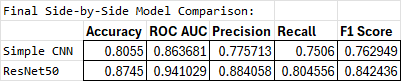

Therefore, the ResNet model was selected as the final model for this evaluation and the submission was uploaded to Kaggle.  Interestingly, the returned score from Kaggle was a bit lower than the test data that we performed here.  That might signal some overfitting or other issues with the model itself, but overall it works as intended for our purposes.
